# Import necessary libraries

In [1]:
import glob
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Create a custom dataset class to load and preprocess the cat images and their annotations

In [2]:
class CatDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_paths = glob.glob(os.path.join(image_dir, '**/*.jpg'), recursive=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        
        annotation_path = img_path + '.cat'
        with open(annotation_path, 'r') as f:
            annotations = list(map(int, f.readline().split()[1:]))
        
        original_width, original_height = img.size
        target_width, target_height = 64, 64
        
        # Scale annotations
        annotations[0::2] = [x * (target_width / original_width) for x in annotations[0::2]]
        annotations[1::2] = [y * (target_height / original_height) for y in annotations[1::2]]
        
        annotations = torch.tensor(annotations)
        
        if self.transform:
            img = self.transform(img)
        
        return img, annotations

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [3]:
image_dir = "C:/Users/osyed/OneDrive/Desktop/AIML Assessment project"
dataset = CatDataset(image_dir, transform=transform)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

Sample Image Dimensions (HxW): 64 64
Sample Annotations: tensor([23.4375, 24.7166, 27.2500, 24.4347, 25.5625, 27.8179, 20.7500, 21.2394,
        19.9375, 14.7548, 22.6875, 17.4802, 27.4375, 16.8223, 29.5000, 13.7210,
        29.6875, 20.2056])


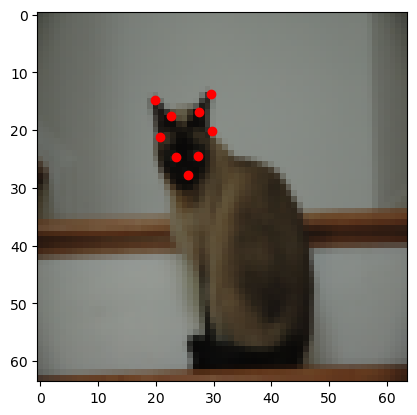

In [4]:
# Visualize a sample image and its annotations
sample_img, sample_annotations = dataset[5]
print("Sample Image Dimensions (HxW):", sample_img.shape[1], sample_img.shape[2])
print("Sample Annotations:", sample_annotations)
plt.imshow(sample_img.permute(1, 2, 0))
plt.scatter(sample_annotations[0::2], sample_annotations[1::2], c='red')
plt.show()

In [5]:
class DiffusionModel(nn.Module):
    def __init__(self, num_steps=1000):
        super().__init__()
        self.num_steps = num_steps
        self.beta = torch.linspace(1e-4, 0.02, num_steps)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        
        self.unet = nn.Sequential(
            nn.Conv2d(6, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 3, 3, padding=1)
        )
    
    def forward(self, x, t):
        t = t.float() / self.num_steps
        t = t.view(-1, 1, 1, 1).repeat(1, 3, 64, 64)
        x = torch.cat([x, t], dim=1)
        return self.unet(x)

    def add_noise(self, x, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])
        epsilon = torch.randn_like(x)
        return sqrt_alpha_bar.view(-1, 1, 1, 1) * x + sqrt_one_minus_alpha_bar.view(-1, 1, 1, 1) * epsilon, epsilon

model = DiffusionModel()  # Remove .cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Epoch 1/5: 100%|█████████████████████████████████████████████████████████████████████| 625/625 [54:13<00:00,  5.21s/it]


Epoch 1/5, Train Loss: 0.7920, Val Loss: 0.6191


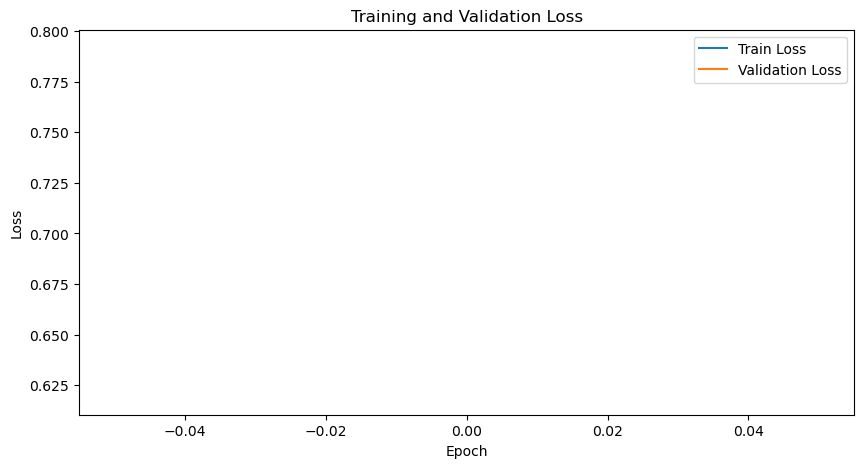

Epoch 2/5: 100%|█████████████████████████████████████████████████████████████████████| 625/625 [22:31<00:00,  2.16s/it]


Epoch 2/5, Train Loss: 0.5167, Val Loss: 0.4260


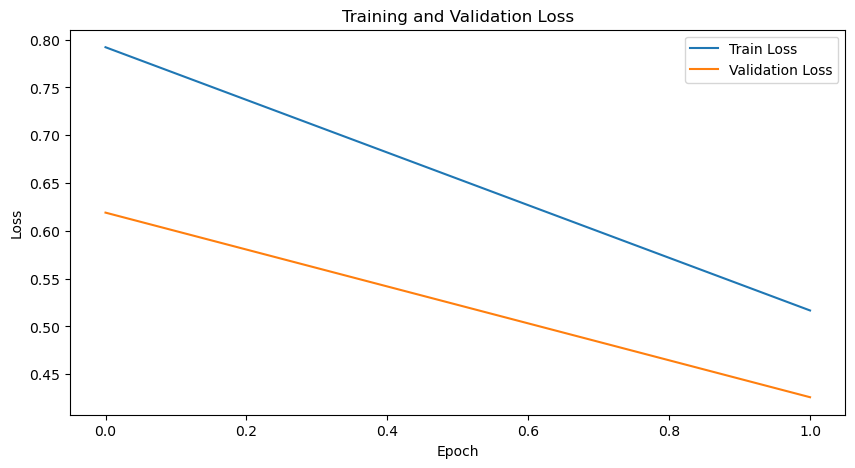

Epoch 3/5: 100%|█████████████████████████████████████████████████████████████████████| 625/625 [22:01<00:00,  2.11s/it]


Epoch 3/5, Train Loss: 0.3571, Val Loss: 0.3044


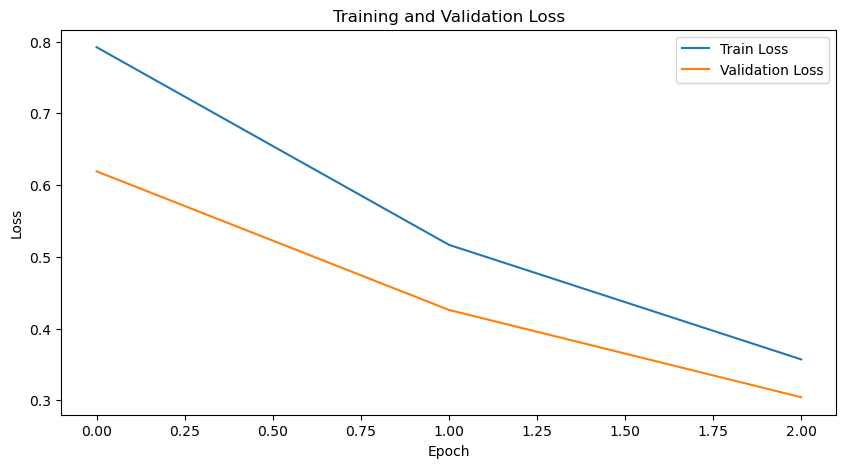

Epoch 4/5: 100%|█████████████████████████████████████████████████████████████████████| 625/625 [22:09<00:00,  2.13s/it]


Epoch 4/5, Train Loss: 0.2565, Val Loss: 0.2203


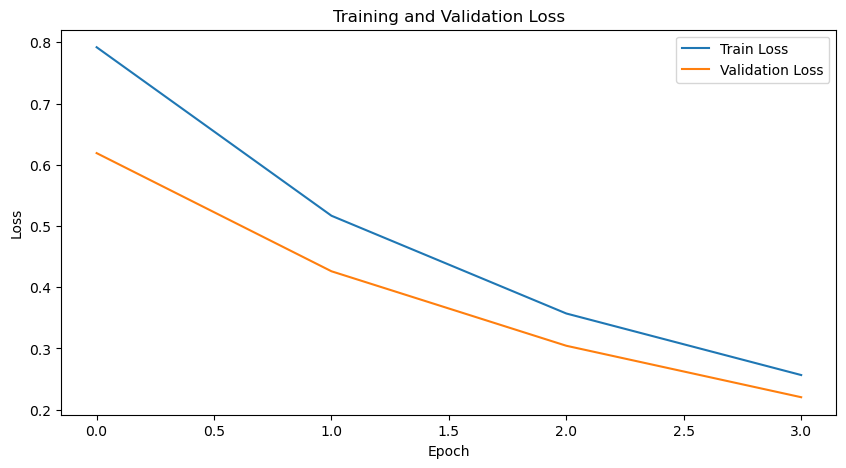

Epoch 5/5: 100%|█████████████████████████████████████████████████████████████████████| 625/625 [52:28<00:00,  5.04s/it]


Epoch 5/5, Train Loss: 0.1973, Val Loss: 0.1724


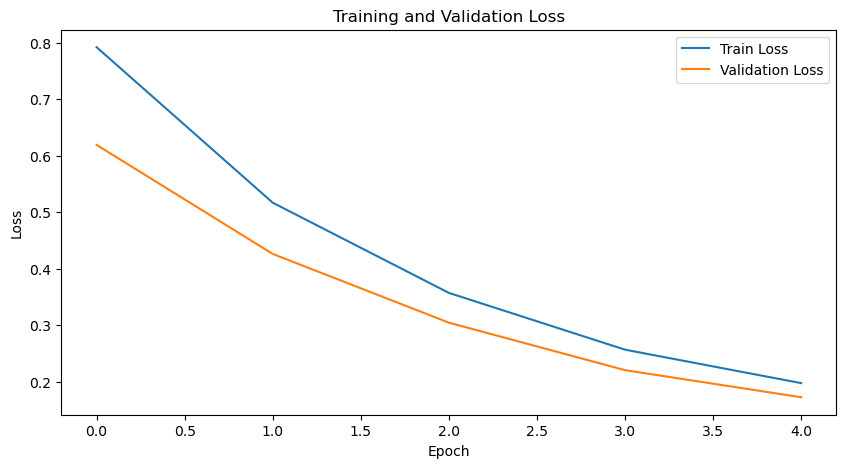

In [6]:
def train(model, dataloader, num_epochs=5):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0
        
        for images, _ in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            optimizer.zero_grad()
            
            t = torch.randint(0, model.num_steps, (images.shape[0],))
            noisy_images, noise = model.add_noise(images, t)
            predicted_noise = model(noisy_images, t)
            
            loss = nn.MSELoss()(predicted_noise, noise)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, _ in dataloader:
                t = torch.randint(0, model.num_steps, (images.shape[0],))
                noisy_images, noise = model.add_noise(images, t)
                predicted_noise = model(noisy_images, t)
                val_loss += nn.MSELoss()(predicted_noise, noise).item()
        
        avg_val_loss = val_loss / len(dataloader)
        val_losses.append(avg_val_loss)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # Plot losses
        plt.figure(figsize=(10, 5))
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    return train_losses, val_losses

train_losses, val_losses = train(model, data_loader)

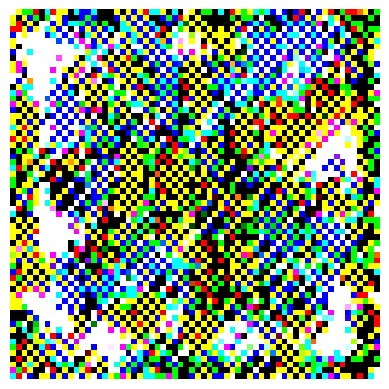

In [8]:
@torch.no_grad()
def generate_image(model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    x = torch.randn(1, 3, 64, 64, device=device)
    
    for t in reversed(range(model.num_steps)):
        t_tensor = torch.full((1,), t, dtype=torch.long, device=device)
        predicted_noise = model(x, t_tensor)
        alpha_t = model.alpha[t]
        alpha_bar_t = model.alpha_bar[t]
        beta_t = model.beta[t]
        
        if t > 0:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
        
        x = (1 / torch.sqrt(alpha_t)) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * predicted_noise) + torch.sqrt(beta_t) * noise
    
    x = (x.clamp(-1, 1) + 1) / 2
    x = x.cpu().squeeze().permute(1, 2, 0).numpy()
    
    plt.imshow(x)
    plt.axis('off')
    plt.show()

# Generate an image
generate_image(model)

In [9]:
import torch

# After training, save the model
model_path = "CatDiffusionModel.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to CatDiffusionModel.pth


In [10]:
# Load the model
model_path = "CatDiffusionModel.pth"
model = DiffusionModel()  # Initialize the model
model.load_state_dict(torch.load(model_path))
model.eval()
print(f"Model loaded from {model_path}")


Model loaded from CatDiffusionModel.pth
